In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

from Action import action
from Observation import observation
from Function_prop_score import MonteCarlo_prop_score


def Run(K, snr, X):
    SNR = snr
    T = 10000
    gamma = 0.01
    # initialization
    A = [action(T) for i in range(0, K)]
    Best_reward = -10
    Best_arm = 0
    Best_arm_estimator = 0
    for a in range(0, K):
        A[a].reward = np.random.normal(0, SNR)
        # record best arm and best reward
        if Best_reward < A[a].reward:
            Best_reward = A[a].reward
            Best_arm = a

    Best_reward_estimator = np.zeros(T + 1)
    available_action = [i for i in range(0, K)]

    # initialization of three estimators in the algorithm
    k = K
    tao = np.zeros((T + 2, k))
    miu_reward_estimator = np.zeros((T + 2, k))
    sigma_estimator = np.zeros((T + 2, k))

    # First Observation
    for x in range(0, X):
        for a in range(0, k):
            A[a].reward_mean = observation(A[a]).value
            A[a].pro_score[1] = 1 / k

    # loop begin
    for t in range(1, T + 1):

        # calculate cumulative regret at time t
        for a in available_action:   Best_reward_estimator[t] += A[a].pro_score[t] * A[a].reward

        # pull arm
        a_t = np.random.multinomial(1, [A[j].pro_score[t] for j in available_action])
        a_t = available_action[np.argwhere(a_t == 1)[0, 0]]

        # observe and update sample averages and counts
        ob = observation(A[a_t])
        re_past = A[a_t].reward_mean
        A[a_t].update_rm_n(ob)

        # update sampling distribution
        for a in available_action:
            tao[t, a] = re_past + (ob.value - re_past) / A[a].pro_score[t] if a == a_t else A[
                a].reward_mean

            s1 = sum(np.sqrt(A[a].pro_score[1:t + 1]) * tao[1:t + 1, a])
            s2 = sum(np.sqrt(A[a].pro_score[1:t + 1]))
            miu_reward_estimator[t, a] = s1 / s2

            s3 = sum([A[a].pro_score[s] * ((tao[s, a] - miu_reward_estimator[t, a]) ** 2 + 1) for s in range(1, t + 1)])
            sigma_estimator[t, a] = s3 / (s2 * s2)

        # arm elimination
        rem = []
        for a in available_action:
            p = 1
            for a1 in available_action:
                if a != a1:
                    p1 = norm.cdf((miu_reward_estimator[t, a] - miu_reward_estimator[t, a1]) / (
                            (sigma_estimator[t, a] ** 2 + sigma_estimator[t, a1] ** 2) ** 0.5))
                    p = min(p, p1)

            if p < 1 / T:
                rem.append(a)
                k -= 1

        for a in rem:
            available_action.remove(a)

        # compute propensity scores
        Prop_score = MonteCarlo_prop_score(miu_reward_estimator[t], sigma_estimator[t], available_action)
        for a in available_action:
            A[a].pro_score[t + 1] = Prop_score[a]
            A[a].pro_score[t + 1] = (1 - gamma) * A[a].pro_score[t + 1] + gamma / k

        # break after finding the best arm
        if len(available_action) == 1:
            Best_arm_estimator = available_action[0]
            print('END!')
            print('Best arm is the ' + str(Best_arm_estimator) + 'th arm.')
            break

        if len(available_action) == 0:
            print('end!')
            Best_arm_estimator = rem[0]
            for a in rem:
                Best_arm_estimator = a if A[a].reward_mean > A[Best_arm_estimator].reward_mean else Best_arm_estimator
            print('Best arm is the ' + str(Best_arm_estimator) + 'th arm.')
            break

    # print and calculate the best arm, cumulative regret arm*'s regret stopping time
    print('K=' + str(K) + '  t=' + str(t))
    cumulative_regret = sum(Best_reward - Best_reward_estimator[1:t + 1]) / t
    Regret = Best_reward - A[Best_arm_estimator].reward
    print('cumulative regret=' + str(cumulative_regret) + '    Arm* regret=' + str(Regret))
    print("{:-^25s}".format(""))
    return [cumulative_regret, Regret, t]

In [7]:
# Cu_Regret[k,i] stands for the cumulative regret at the ith loop. Regret and stop_time are defined similarly.
Cu_Regret = np.zeros((10, 64))
Regret = np.zeros((10, 64))
stop_time = np.zeros((10, 64))
for k in range(0, 10):
    for i in range(0, 64):
        Cu_Re, Re, st = Run(5 * k + 5, 0.5, 1)
        Cu_Regret[k, i] += Cu_Re
        stop_time[k, i] += st
        Regret[k, i] = Re
    print('For k=' + str(5*k+5) + ', the regret Average is ' + str(np.mean(Cu_Regret[k])))
    print("{:=^100s}".format(""))

END!
Best arm is the 3th arm.
K=5  t=28
cumulative regret=0.034452649055718654    Arm* regret=0.0
-------------------------
END!
Best arm is the 0th arm.
K=5  t=13
cumulative regret=0.11575425416446566    Arm* regret=0.0
-------------------------
END!
Best arm is the 1th arm.
K=5  t=29
cumulative regret=0.045010257428335795    Arm* regret=0.0
-------------------------
END!
Best arm is the 1th arm.
K=5  t=179
cumulative regret=0.02049952807675743    Arm* regret=0.0
-------------------------
END!
Best arm is the 3th arm.
K=5  t=82
cumulative regret=0.018670008658858105    Arm* regret=0.0
-------------------------
END!
Best arm is the 3th arm.
K=5  t=16
cumulative regret=0.09557843622733764    Arm* regret=0.0
-------------------------
END!
Best arm is the 3th arm.
K=5  t=19
cumulative regret=0.10159383431638033    Arm* regret=0.0
-------------------------
END!
Best arm is the 3th arm.
K=5  t=10
cumulative regret=0.20590541325216843    Arm* regret=0.0
-------------------------
END!
Best ar

In [8]:
# save the outcome to an frame
FinalData = {"Cu_Regret": np.mean(Cu_Regret, axis = 1), "stopping_time": np.mean(stop_time, axis = 1),
             "Regret": np.mean(Regret, axis = 1)}
df = pd.DataFrame(FinalData)
df.to_excel('./Result-High-SNR.xlsx', index = False)


In [9]:
# calculate standard error to plot a figure
Cu_Re_std = np.zeros(10)
Re_std = np.zeros(10)
St_std = np.zeros(10)
for k in range(0, 10):
    Cu_Re_std[k] = np.std(Cu_Regret[k])
    Re_std[k] = np.std(Regret[k])
    St_std[k] = np.std(stop_time[k])


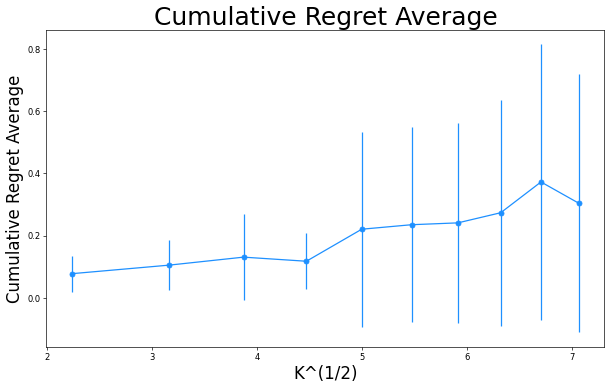

In [10]:
# plot the figure of cumulative regret
K = np.sqrt(np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]))
plt.figure(figsize = (12, 7), dpi = 60)
plt.errorbar(K, np.mean(Cu_Regret, axis = 1), Cu_Re_std, fmt = 'o-', ecolor = 'dodgerblue', color = 'dodgerblue')
plt.title('Cumulative Regret Average', fontsize = 30)
plt.xlabel('K^(1/2)', fontsize = 20)
plt.ylabel('Cumulative Regret Average', fontsize = 20)
plt.savefig('./Cumulative_Regret_Average-High-SNR.png')


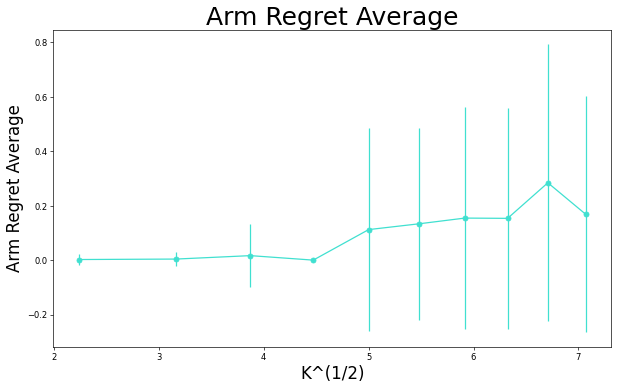

In [11]:
# plot the figure of arm*'s regret
K = np.sqrt(np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]))
plt.figure(figsize = (12, 7), dpi = 60)
plt.errorbar(K, np.mean(Regret, axis = 1), Re_std, fmt = 'o-', ecolor = 'turquoise', color = 'turquoise')
plt.title('Arm Regret Average', fontsize = 30)
plt.xlabel('K^(1/2)', fontsize = 20)
plt.ylabel('Arm Regret Average', fontsize = 20)
plt.savefig('./Arm_Regret_Average-High-SNR.png')

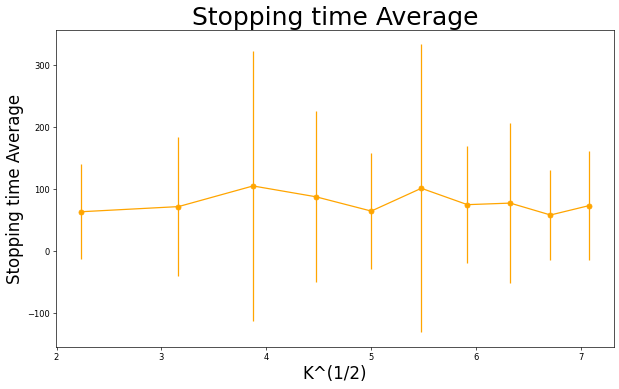

In [12]:
# plot the figure of stopping
K = np.sqrt(np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]))
plt.figure(figsize = (12, 7), dpi = 60)
plt.errorbar(K, np.mean(stop_time, axis = 1), St_std, fmt = 'o-', ecolor = 'orange', color = 'orange')
plt.title('Stopping time Average', fontsize = 30)
plt.xlabel('K^(1/2)', fontsize = 20)
plt.ylabel('Stopping time Average', fontsize = 20)
plt.savefig('./Stopping_time_Average-High-SNR.png')